# Fine-tuning SAM2

## Fine-tuning 

In [1]:
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
sys.path.append("/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2")

In [3]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [4]:
# - Load data and convert them in pngs and save paths in dictionary
## - process raw image tif
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image'
raw_image_tif_path = raw_image_dir / os.listdir(raw_image_dir)[0]
save_dir = data_dir / 'image_pngs'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with Image.open(raw_image_tif_path) as img:
    for i in range(img.n_frames):
        temp_filename = f'image{i:04d}.png'
        if os.path.exists(save_dir / temp_filename):
            continue
        img.seek(i)
        img.save(save_dir / temp_filename)


In [5]:
## - process label image tif
label_image_dir = data_dir / 'seg'
label_image_tif_path = label_image_dir / os.listdir(label_image_dir)[0]
save_seg_dir = data_dir / 'seg_pngs'
if not os.path.exists(save_seg_dir):
    os.makedirs(save_seg_dir)

with Image.open(label_image_tif_path) as img:
    for i in range(img.n_frames):
        temp_filename = f'seg{i:04d}.png'
        if os.path.exists(save_seg_dir / temp_filename):
            continue
        img.seek(i)
        img.save(save_seg_dir / temp_filename)

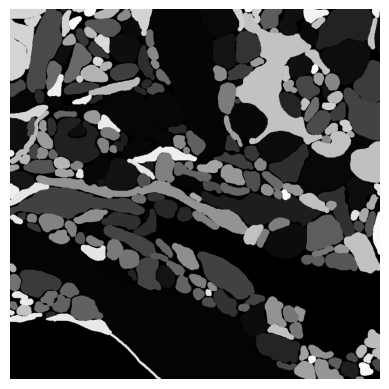

In [6]:
## - show segmentation image with 16 bits
def show_uint16_image_efficient(image_path):
    img = Image.open(image_path)

    img_array = np.array(img)

    max_id = np.max(img_array)

    plt.imshow(img_array, cmap='gray', vmin=0, vmax=max_id+1)
    plt.axis('off')
    plt.show()

show_uint16_image_efficient(save_seg_dir / 'seg0005.png')

In [7]:
## - prepare dataset path collections in dictionary 
data = []
for ff, name in enumerate(os.listdir(save_dir)):
    data.append({'image': save_dir / f'image{ff:04d}.png', 'annotation': save_seg_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]
data = data[:80]

In [8]:
ent  = data[np.random.randint(len(data))] # choose random entry
Img = cv2.imread(str(ent["image"]), cv2.IMREAD_GRAYSCALE) # read image
ann_map = Image.open(ent['annotation'])
np.unique(ann_map)

array([  0,   1,   2,   4,   6,   7,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  21,  22,  23,  24,  32,  36,  42,  43,  45,
        46,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  63,
        64,  66,  67,  68,  69,  70,  74,  76,  77,  78,  79,  80,  81,
        83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,  96,  97,
        98, 103, 104, 107, 108, 109, 110, 112, 113, 116, 117, 119, 120,
       121, 122, 124, 125, 126, 133, 135, 137, 138, 140, 141, 146, 147,
       149, 152, 154, 155, 156, 157, 159, 160, 161, 163, 164, 166, 167,
       168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 197,
       198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 224, 225, 226,
       227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 244, 245, 246, 248, 249, 252, 254, 258, 260, 26

In [9]:
def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)

   #  select image

     ent  = data[np.random.randint(len(data))] # choose random entry
     Img = cv2.imread(str(ent["image"])) # read image
     ann_map_grayscale = np.array(Image.open(ent['annotation']))
     ann_map = np.stack((ann_map_grayscale, ) * 3, axis = -1)
     print(f'image shape: {np.array(Img).shape}')
     print(f'annotation shape: {np.array(ann_map).shape}')
   # resize image

     r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
     Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
     ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

     # - get bounding box
     mat_map = mask
     inds = np.unique(mat_map)[1:] # load all indices

masks = [] 
for ind in inds:

    masks.append(mask == ind)

masks = np.array(masks)
masks_tensor = torch.from_numpy(masks)

boxes = masks_to_boxes(masks_tensor)
input_boxes = boxes.numpy()



   # Get binary masks and points
     mat_map = ann_map
     inds = np.unique(mat_map)[1:] # load all indices
     points= []
     masks = [] 
     for ind in inds:
          mask=(mat_map == ind).astype(np.uint8) # make binary mask
          masks.append(mask)
          coords = np.argwhere(mask > 0) # get all coordinates in mask
          yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
          points.append([[yx[1], yx[0]]])
     return Img,np.array(masks),np.array(points), np.ones([len(masks),1])
img, mask_arr,  point_arr, one_arr= read_batch(data)

image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)


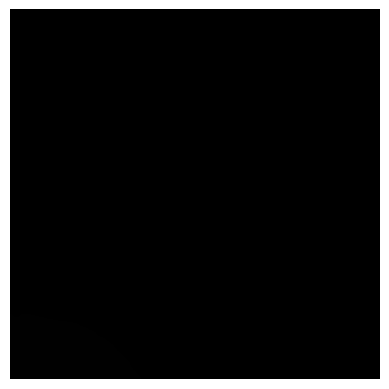

In [10]:
## - visualize some mask samples
def visualize_img(img_array):
    max_id = np.max(img_array)

    plt.imshow(img_array, cmap='gray', vmin=0, vmax=max_id+1)
    plt.axis('off')
    plt.show()
visualize_img(mask_arr[0])
    

In [11]:
len(mask_arr)

210

In [12]:
# - load checkpoints and start fine-tuning (need to load python path to get checkpoint file)

sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"


In [13]:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cpu')
predictor = SAM2ImagePredictor(sam2_model)

In [14]:
## - set training parametres:
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)
predictor.model.image_encoder.train(True)



ImageEncoder(
  (trunk): Hiera(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    )
    (blocks): ModuleList(
      (0-1): 2 x MultiScaleBlock(
        (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
        (attn): MultiScaleAttention(
          (qkv): Linear(in_features=144, out_features=432, bias=True)
          (proj): Linear(in_features=144, out_features=144, bias=True)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (layers): ModuleList(
            (0): Linear(in_features=144, out_features=576, bias=True)
            (1): Linear(in_features=576, out_features=144, bias=True)
          )
          (act): GELU(approximate='none')
        )
      )
      (2): MultiScaleBlock(
        (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), paddi

In [15]:
### - optimizer and scaler
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)

scaler = torch.amp.GradScaler()

In [16]:
# - force cuda operations to be synchronized
!export CUDA_LAUNCH_BLOCKING=1

In [20]:
input_point.shape

(218, 1, 2)

In [17]:
# - fine-tuning
# - try to improve efficiency by doing min-batch stochastic gradient descent. this is just stochastic gradient descent
import torch.nn as nn

device0 = torch.device('cuda:0')
device1 = torch.device('cuda:1')
device_cpu = torch.device('cpu')

for itr in range(10000):
    with torch.amp.autocast(device_type='cpu'):
        image, mask, input_point, input_label = read_batch(data)
        if mask.shape[0] == 0: continue
        predictor.set_image(image)

        # - prompt encoding
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels), boxes=None, masks=None)


        # - mask decoder
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=[feat for feat in high_res_features],
        )


        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        # - segmentation loss calculation on CPU
        gt_mask = torch.tensor(mask.astype(np.float32))[:, :, :, 0]
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        # - score loss calculation (intersection over union) IOU on CPU
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

        # Move the total loss to GPU for backpropagation
        loss = (seg_loss + score_loss * 0.05)
        predictor.model.zero_grad()  # empty gradient
        scaler.scale(loss).backward()  # Backpropagate
        scaler.step(optimizer)
        scaler.update()  # Mix precision

        if itr % 1000 == 0:
            torch.save(predictor.model.state_dict(), f"./checkpoints/large_model_box{itr}.torch")
            print("save model")

        if itr == 0:
            mean_iou = 0
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        print("step)", itr, "Accuracy(IOU)=", mean_iou)


image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
save model
step) 0 Accuracy(IOU)= 0.005618165731430054
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 1 Accuracy(IOU)= 0.010846342933177948
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 2 Accuracy(IOU)= 0.016502163041710854
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 3 Accuracy(IOU)= 0.021852115409363507
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 4 Accuracy(IOU)= 0.02700822017651926
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 5 Accuracy(IOU)= 0.031361497714534496
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 6 Accuracy(IOU)= 0.036314997972717825
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 7 Accuracy(IOU)= 0.04136684712037864
image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)
step) 8 Accuracy(IOU)= 0.04670522237323491
image shape: (1024, 1024, 3)


KeyboardInterrupt: 

In [18]:
torch.save(predictor.model.state_dict(), f"./checkpoints/large_model_box{itr + 1}.torch")

In [ ]:
# ### - main training loop; does SAM requires RGB???
# import torch.nn as nn

# device0 = torch.device('cuda:0')
# device1 = torch.device('cuda:1')

# for itr in range(100000):
#     with torch.amp.autocast(device_type='cuda'):
#         image, mask, input_point, input_label = read_batch(data)
#         if mask.shape[0] == 0: continue
#         predictor.set_image(image)

#         print('*******************Start to do prompt encoding*******************')
#         # - prompt encoding
#         mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits = None, normalize_coords = True)
#         sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points = (unnorm_coords, labels), boxes = None, masks=None)

#         print('*******************Start to do mask decoder*******************')
#         # - mask decoder
#         batched_mode = unnorm_coords.shape[0] > 1
#         high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
#         low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
#         prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

#         print('*******************Start to calculate loss*******************')
#         # - segmentation loss calculation
#         gt_mask = torch.tensor(mask.astype(np.float32))[:, :, :, 0].to(device1)
#         prd_mask = torch.sigmoid(prd_masks[:, 0]).to(device1)
#         print(f'gt_mask shape: {gt_mask.shape}')
#         print(f'prd_mask shape: {prd_mask.shape}')
#         print(f'prd_mask shape: {prd_masks.shape}')
#         seg_loss =  (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

#         print('start to add iou into loss')
#         # - score loss calculation (intersecition over union) IOU

#         inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
#         iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
#         prd_scores = prd_scores.to(device1)
#         iou = iou.to(device1)
#         score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
#         loss=seg_loss+score_loss*0.05  # mix losses
        
#         print('*******************Start to do gradient descent*******************')
#         predictor.model.zero_grad() # empty gradient
#         scaler.scale(loss).backward()  # Backpropogate
#         scaler.step(optimizer)
#         scaler.update() # Mix precision


#         if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch");print("save model")

#         # Display results

#         if itr==0: mean_iou=0
#         mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
#         print("step)",itr, "Accuracy(IOU)=",mean_iou)

### Florence 2 Finetuning Task